Define glaciers for the run

In [1]:
from oggm import utils
utils.get_rgi_dir(version='62')  # path to the data after download

'/home/dcl/OGGM/rgi/RGIV62'

In [2]:
fr = utils.get_rgi_region_file(13, version='62')  # Central Asia
# fr = utils.get_rgi_region_file(11, version='62')  # Central Europe

In [3]:
import geopandas as gpd
gdf = gpd.read_file(fr)

In [4]:
gdf_sel = gdf.loc[gdf.O2Region == '7']

Import necessary software packages for graphing and visualization

In [5]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely.geometry as shpg

import and set up OGGM software

In [6]:
from oggm import cfg, utils, workflow, tasks, graphics

In [7]:
from oggm import cfg, workflow, tasks, DEFAULT_BASE_URL
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['border'] = 80

# !!!注意地址在第一次跑成功之后需要更改
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-qilianshan_v1', reset=True) 

2024-08-11 14:25:13: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-08-11 14:25:13: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-08-11 14:25:13: oggm.cfg: Multiprocessing: using all available processors (N=22)
2024-08-11 14:25:15: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2024-08-11 14:25:15: oggm.cfg: Multiprocessing switched ON after user settings.


In [8]:
cfg.PATHS['working_dir']

'/tmp/OGGM/OGGM-qilianshan_v1'

In [9]:
gdirs = workflow.init_glacier_directories(gdf_sel, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=5)

2024-08-11 14:25:19: oggm.workflow: init_glacier_directories from prepro level 5 on 2730 glaciers.
2024-08-11 14:25:19: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2730 glaciers


Initiate climate runs

In [10]:
import oggm.cfg
from oggm import utils, workflow, tasks, graphics
from oggm.sandbox.edu import run_constant_climate_with_bias
oggm.cfg.PARAMS['store_model_geometry'] = True

2024-08-11 14:25:42: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


2024-08-11 14:25:42: oggm.utils: Applying global task compile_run_output on 1 glaciers
2024-08-11 14:25:42: oggm.utils: Applying compile_run_output on 1 gdirs.


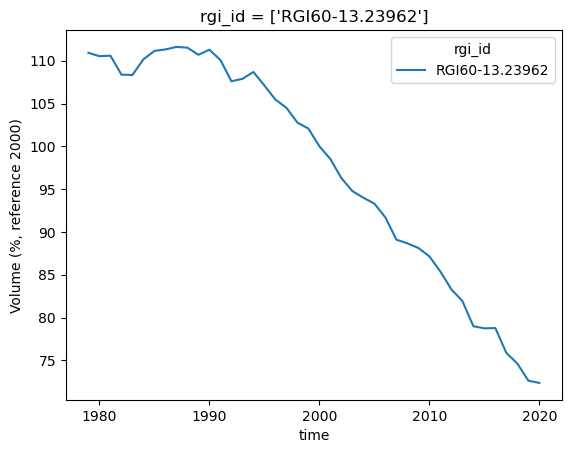

In [11]:
ds = utils.compile_run_output(gdirs[0], input_filesuffix='_spinup_historical')
(ds.volume / ds.volume.sel(time=2000) * 100).plot(hue='rgi_id');
plt.ylabel('Volume (%, reference 2000)');

In [12]:
from oggm.shop.gcm_climate import process_monthly_isimip_data, process_cmip_data

In [13]:
# preprocess climate files 

# we compute both ISIMIP3b_CMIP6 and CMIP6 in one run

# preprocess ISIMIP3b_CMIP6
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
isimip3b_members = ['gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1',
                    'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ]
for member in isimip3b_members:
    # Download the three main SSPs
    for ssp in ['ssp126', 'ssp370','ssp585']:
        # bias correct them
        rid = f'_ISIMIP3b_{member}_{ssp}'
        workflow.execute_entity_task(process_monthly_isimip_data, gdirs, 
                                        ssp = ssp,
                                        # gcm member -> you can choose another one
                                        member=member,
                                        # recognize the climate file for later
                                        output_filesuffix=rid,
                                        y0=2000, # no additional bias correction anyways ...
                                        );


2024-08-11 14:25:44: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 2730 glaciers


  0% of  18.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  18.6 MiB |######################| Elapsed Time: 0:00:02 Time:  0:00:02
  0% of  35.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  35.6 MiB |######################| Elapsed Time: 0:00:10 Time:  0:00:10
2024-08-11 14:26:08: oggm.shop.gcm_climate: OSError occurred during task process_monthly_isimip_data_ISIMIP3b_gfdl-esm4_r1i1p1f1_ssp126 on RGI60-13.23963: [Errno -101] NetCDF: HDF error: '/home/dcl/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/cmip6/isimip3b/flat/2023.2/monthly/gfdl-esm4_r1i1p1f1_w5e5_historical_tasAdjust_global_monthly_flat_glaciers.nc'
2024-08-11 14:26:08: oggm.shop.gcm_climate: OSError occurred during task process_monthly_isimip_data_ISIMIP3b_gfdl-esm4_r1i1p1f1_ssp126 on RGI60-13.23964: [Errno -101] NetCDF: HDF error: '/home/dcl/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/cmip6/isimip3b/flat/2023.2/monthly/gfdl-esm4_r1i1p1f1_w5e5_hist

In [14]:
gdirs[0].get_climate_info()

{'baseline_climate_source': 'GSWP3_W5E5',
 'baseline_yr_0': 1901,
 'baseline_yr_1': 2019,
 'baseline_climate_ref_hgt': 4252.0,
 'baseline_climate_ref_pix_lon': 98.75,
 'baseline_climate_ref_pix_lat': 38.25}

In [15]:
for ssp in ['ssp126', 'ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                 climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                 climate_input_filesuffix=rid,  # use the chosen scenario
                                 init_model_filesuffix='_spinup_historical',  # this is important! Start from 2020 glacier
                                 output_filesuffix=rid,  # recognize the run for later
                                );

2024-08-11 15:36:06: oggm.workflow: Execute entity tasks [run_from_climate_data] on 2730 glaciers
2024-08-11 15:37:05: oggm.workflow: Execute entity tasks [run_from_climate_data] on 2730 glaciers
2024-08-11 15:38:00: oggm.workflow: Execute entity tasks [run_from_climate_data] on 2730 glaciers


2024-08-11 15:36:07: oggm.core.flowline: FileNotFoundError occurred during task run_from_climate_data_ISIMIP3b_ukesm1-0-ll_r1i1p1f2_ssp126 on RGI60-13.23963: [Errno 2] No such file or directory: '/tmp/OGGM/OGGM-qilianshan_v1/per_glacier/RGI60-13/RGI60-13.23/RGI60-13.23963/gcm_data_ISIMIP3b_ukesm1-0-ll_r1i1p1f2_ssp126.nc'
2024-08-11 15:36:13: oggm.core.flowline: FileNotFoundError occurred during task run_from_climate_data_ISIMIP3b_ukesm1-0-ll_r1i1p1f2_ssp126 on RGI60-13.31528: [Errno 2] No such file or directory: '/tmp/OGGM/OGGM-qilianshan_v1/per_glacier/RGI60-13/RGI60-13.31/RGI60-13.31528/model_geometry_spinup_historical.nc'
2024-08-11 15:36:20: oggm.core.flowline: FileNotFoundError occurred during task run_from_climate_data_ISIMIP3b_ukesm1-0-ll_r1i1p1f2_ssp126 on RGI60-13.31835: [Errno 2] No such file or directory: '/tmp/OGGM/OGGM-qilianshan_v1/per_glacier/RGI60-13/RGI60-13.31/RGI60-13.31835/model_geometry_spinup_historical.nc'
2024-08-11 15:36:20: oggm.core.flowline: FileNotFoundErro

In [27]:
import os
for member in isimip3b_members:    
        for ssp in ['ssp126', 'ssp370', 'ssp585']:
                rid = f'_ISIMIP3b_{member}_{ssp}'
                utils.compile_run_output(gdirs, input_filesuffix=f'_merged_from_2000_run{rid}')

2024-08-11 16:05:11: oggm.utils: Applying global task compile_run_output on 2730 glaciers
2024-08-11 16:05:11: oggm.utils: Applying compile_run_output on 2730 gdirs.


RuntimeError: Found no valid glaciers!

In [23]:
new_ds_nor

2024-08-11 15:44:59: oggm.utils: Applying global task compile_run_output on 2730 glaciers
2024-08-11 15:44:59: oggm.utils: Applying compile_run_output on 2730 gdirs.


AttributeError: 'NoneType' object has no attribute 'isel'

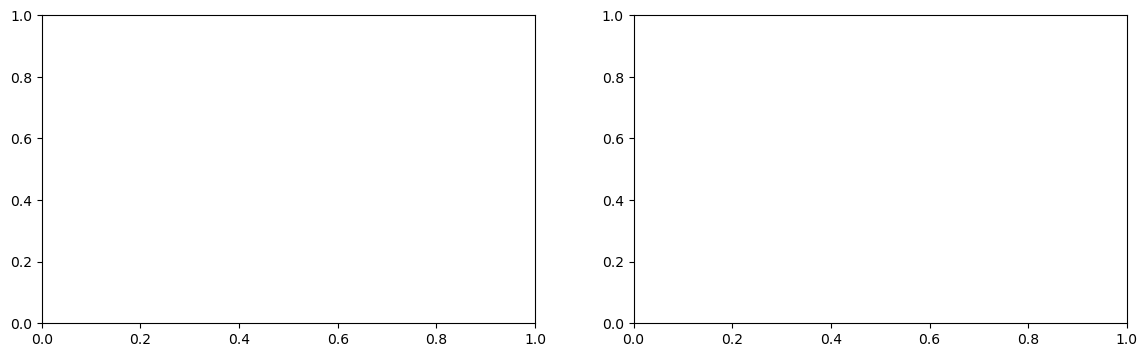

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
# Pick some colors for the lines
color_dict={'ssp126':'blue', 'ssp370':'orange', 'ssp585':'red'}
for ssp in ['ssp126','ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    # Compile the output into one file
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
    # Plot it
    ds.isel(rgi_id=0).volume.plot(ax=ax1, label=ssp, c=color_dict[ssp]);
    ds.isel(rgi_id=1).volume.plot(ax=ax2, label=ssp, c=color_dict[ssp]);
plt.legend();